In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import imageio
import os
import shutil

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Function to generate the time string based on date and time of day
def generate_time(date, time_of_day):
    # Convert date string to datetime object
    date_obj = datetime.strptime(date, '%Y%m%d')
    # Format the date part
    date_str = date_obj.strftime('%Y-%m-%d')
    # Combine date and time of day
    time_str = f'{date_str}T{time_of_day}'
    return time_str

def plot_rgb_image(ds, date, time_of_day, gif=False):
    """""
    Plot RGB image from xarray dataset and save as PNG.
    Parameters:
    ds (xarray.Dataset): The dataset containing the RGB channels.
    date (str): The date in 'YYYYMMDD' format.
    time_of_day (str): The time of day in 'HH:MM:SS' format.
    gif (bool): Whether to save the plot as a GIF.
    """

    # Extract the values as NumPy arrays
    red = ds['red'].values
    green = ds['green'].values
    blue = ds['blue'].values

    # Find the minimum shape among the arrays
    min_shape = np.min([red.shape, green.shape, blue.shape], axis=0)

    # Resize the arrays to the minimum shape
    red_resized = red[:min_shape[0], :min_shape[1]]
    green_resized = green[:min_shape[0], :min_shape[1]]
    blue_resized = blue[:min_shape[0], :min_shape[1]]

    # Ensure the arrays have the same dimensions
    assert red_resized.shape == green_resized.shape == blue_resized.shape, "Arrays must have the same shape"

    # Stack the arrays along the last dimension to create an RGB image
    rgb_image = np.stack([red_resized, green_resized, blue_resized], axis=-1)

    # Extract longitude and latitude values
    lon = ds['x'].values
    lat = ds['y'].values

    # Plot the RGB image using matplotlib's imshow
    rgb_plot = plt.imshow(rgb_image, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GOES Day Cloud Phase RGB Composite - ' + date + ' ' + time_of_day + ' UTC')
    plt.axis('on')  # Show the axis

    # Save the plot as a PNG file
    filename = f'./plots/goes_RGB_{date}_{time_of_day}.png'
    plt.savefig(filename)

    
    if gif:
        plt.close()
        return filename
    else:
        return rgb_plot
        plt.show()

def create_gif_from_pngs(png_dir, output_gif):
    # Get a list of all PNG files in the directory
    png_files = sorted([f for f in os.listdir(png_dir) if f.endswith('.png')])

    # Read each image and append it to the images list
    images = []
    for png_file in png_files:
        image_path = os.path.join(png_dir, png_file)
        images.append(imageio.imread(image_path))

    # Create and save the GIF
    imageio.mimsave(output_gif, images, duration=0.1)  # Adjust the duration as needed
    



def cloud_mask(ds):
    """
    create a mask where the green channel is greater than 0.5 and blue channel 
    is less than 0.2 set these pixels to red=0, blue=1, green=1

    """

    green = ds['green'].values
    blue = ds['blue'].values
    red = ds['red'].values
    mask = (green > 0.4) & (blue > 0.4) & (red > 0.4)
    ds_masked = ds.copy()
    ds_masked['red'] = xr.where(mask, 0, ds['red'])
    ds_masked['green'] = xr.where(mask, 1, ds['green'])
    ds_masked['blue'] = xr.where(mask, 1, ds['blue'])

    return ds_masked

def make_gif(date, start_time, end_time, mask=False):
    """
    Create a GIF from GOES data for a specific date and time range.

    Parameters:
    date (str): The date in 'YYYYMMDD' format.
    start_time (str): The start time in 'HHMM' format.
    end_time (str): The end time in 'HHMM' format.
    mask (bool): Whether to apply a cloud mask.
    """
    input_file = f'/storage/cdalden/goes/goes16/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc'
    ds = xr.open_dataset(input_file)

    if mask:
        print('Applying cloud mask...')
        ds = cloud_mask(ds)
    else:
        ds = ds


    start_time = datetime.strptime(f"{date}T{start_time}00", '%Y%m%dT%H%M%S')
    end_time = datetime.strptime(f"{date}T{end_time}00", '%Y%m%dT%H%M%S')

    ds = ds.sortby('t')

    # List to store the filenames of the generated plots
    filenames = []

    # Loop through every 10-minute chunk
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%Y-%m-%dT%H:%M:%S')
        ds_i = ds.sel(t=time_str, method='nearest')
        hour_of_day = current_time.strftime('%H:%M')
        filename = plot_rgb_image(ds_i, date, hour_of_day, gif=True)
        filenames.append(filename)
        current_time += timedelta(minutes=10)
        print(f'Generated RGB image for {time_str}')

    # Create the GIF
    start_time_out = start_time.strftime('%H%M')
    end_time_out =  end_time.strftime('%H%M')
    if mask:
        output_gif = f'./gifs/masked_goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'
    else:
        output_gif = f'./gifs/goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'
    with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Clean up the temporary files
    import os
    for filename in filenames:
        os.remove(filename)

In [5]:
date = '20230605'
start_time = '1400'
end_time = '2300'

make_gif(date, start_time, end_time, mask=True)

Applying cloud mask...


Generated RGB image for 2023-06-05T14:00:00
Generated RGB image for 2023-06-05T14:10:00
Generated RGB image for 2023-06-05T14:20:00
Generated RGB image for 2023-06-05T14:30:00
Generated RGB image for 2023-06-05T14:40:00
Generated RGB image for 2023-06-05T14:50:00
Generated RGB image for 2023-06-05T15:00:00
Generated RGB image for 2023-06-05T15:10:00
Generated RGB image for 2023-06-05T15:20:00
Generated RGB image for 2023-06-05T15:30:00
Generated RGB image for 2023-06-05T15:40:00
Generated RGB image for 2023-06-05T15:50:00
Generated RGB image for 2023-06-05T16:00:00
Generated RGB image for 2023-06-05T16:10:00
Generated RGB image for 2023-06-05T16:20:00
Generated RGB image for 2023-06-05T16:30:00
Generated RGB image for 2023-06-05T16:40:00
Generated RGB image for 2023-06-05T16:50:00
Generated RGB image for 2023-06-05T17:00:00
Generated RGB image for 2023-06-05T17:10:00
Generated RGB image for 2023-06-05T17:20:00
Generated RGB image for 2023-06-05T17:30:00
Generated RGB image for 2023-06-

In [5]:



input_file = f'/storage/cdalden/goes/goes16/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc'
ds = xr.open_dataset(input_file)

In [6]:
ds = cloud_mask(ds)

In [9]:
# Define the start and end times
# date = '20230205'
start_time = datetime.strptime(f"{date}T{start_time}00", '%Y%m%dT%H%M%S')
end_time = datetime.strptime(f"{date}T{end_time}00", '%Y%m%dT%H%M%S')

ds = ds.sortby('t')

# List to store the filenames of the generated plots
filenames = []

# Loop through every 10-minute chunk
current_time = start_time
while current_time <= end_time:
    time_str = current_time.strftime('%Y-%m-%dT%H:%M:%S')
    ds_i = ds.sel(t=time_str, method='nearest')
    hour_of_day = current_time.strftime('%H:%M')
    filename = plot_rgb_image(ds_i, date, hour_of_day, gif=True)
    filenames.append(filename)
    current_time += timedelta(minutes=10)
    print(f'Generated RGB image for {time_str}')

# Create the GIF
start_time_out = start_time.strftime('%H%M')
end_time_out =  end_time.strftime('%H%M')
output_gif = f'./gifs/masked_goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'
with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Clean up the temporary files
import os
for filename in filenames:
    os.remove(filename)

Generated RGB image for 2023-02-09T16:00:00
Generated RGB image for 2023-02-09T16:10:00
Generated RGB image for 2023-02-09T16:20:00
Generated RGB image for 2023-02-09T16:30:00
Generated RGB image for 2023-02-09T16:40:00
Generated RGB image for 2023-02-09T16:50:00
Generated RGB image for 2023-02-09T17:00:00
Generated RGB image for 2023-02-09T17:10:00
Generated RGB image for 2023-02-09T17:20:00
Generated RGB image for 2023-02-09T17:30:00
Generated RGB image for 2023-02-09T17:40:00
Generated RGB image for 2023-02-09T17:50:00
Generated RGB image for 2023-02-09T18:00:00
Generated RGB image for 2023-02-09T18:10:00
Generated RGB image for 2023-02-09T18:20:00
Generated RGB image for 2023-02-09T18:30:00
Generated RGB image for 2023-02-09T18:40:00
Generated RGB image for 2023-02-09T18:50:00
Generated RGB image for 2023-02-09T19:00:00
Generated RGB image for 2023-02-09T19:10:00
Generated RGB image for 2023-02-09T19:20:00
Generated RGB image for 2023-02-09T19:30:00
Generated RGB image for 2023-02-

In [8]:
from moviepy.editor import VideoFileClip

# Load the GIF
clip = VideoFileClip(f"/home/cdalden/goes_work/processing/masked_goes_RGB_{date}_{start_time}_{end_time}.gif")
# Check the duration and frame count
print(f"Duration: {clip.duration} seconds")
print(f"FPS: {clip.fps}")
print(f"Frame count: {clip.duration * clip.fps}")
# Save as MP4
# clip.write_videofile(f"goes_RGB_{date}_1600_2300.mp4", codec="libx264", fps=30)

OSError: MoviePy error: the file /home/cdalden/goes_work/processing/masked_goes_RGB_20230209_1600_2300.gif could not be found!
Please check that you entered the correct path.

## Testing

In [3]:
from utils import goes_rad_to_rgb
goes_rad_to_rgb?

Signature: goes_rad_to_rgb(path, date)
Docstring:
Downscale GOES-16 bands C02, C05, and C13 to the same grid and interpolate to match the target dataset.
The function also calculates reflectivity and brightness temperature for the specified bands.

Parameters:
path (str): The path to the directory containing the GOES-16 data files.
date (str): The date string in the format 'YYYYMMDD'.

Returns:
xarray.Dataset: A dataset containing the downscaled reflectivity and brightness temperature.
File:      ~/goes_work/processing/utils.py
Type:      function

In [4]:
path = '/storage/cdalden/goes/goes16/'
date = '20230209'
start_time = '1800'
# ds = goes_rad_to_rgb(path, date)


In [5]:
# ds.to_netcdf(f'{path}/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc')

In [6]:
ds = xr.open_dataset(f'{path}/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc')


In [27]:
# Combine into a full datetime string
datetime_str = f"{date}T{start_time}00"  # Add seconds (00)

# Parse the string into a datetime object
dt = datetime.strptime(datetime_str, '%Y%m%dT%H%M%S')


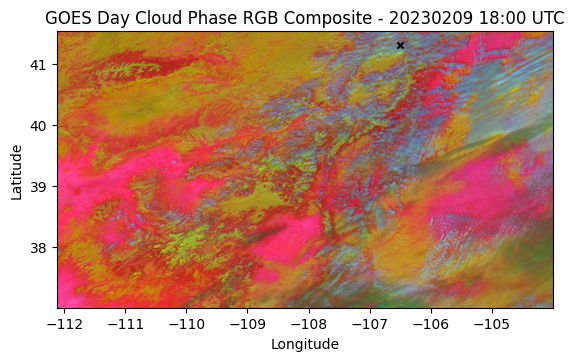

In [21]:
time_of_day = datetime.strptime(datetime_str, '%Y%m%dT%H%M%S')
hour_of_day = time_of_day.strftime('%H:%M')
ds_i = ds.sel(t=time_of_day, method='nearest')
plot_rgb_image(ds_i, date, hour_of_day, gif=False)
plt.scatter(-106.5, 41.3, color='k', marker='x', s=20)

In [26]:
# ds_i.sel(x=-106.5, y=41.3, method='nearest')

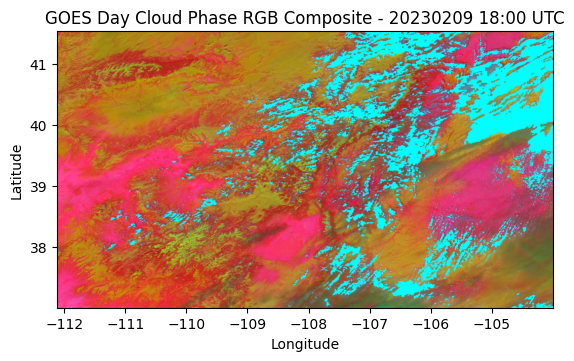

In [25]:
ds_i = ds_masked.sel(t=time_of_day, method='nearest')
plot_rgb_image(ds_i, date, hour_of_day, gif=False)